<a href="https://colab.research.google.com/github/knc6/jarvis-tools-notebooks/blob/master/jarvis-tools-notebooks/BandOffSet_LOCPOT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q git+https://github.com/usnistgov/intermat.git@develop ase

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 27.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 15.8 MB/s eta 0:00:00


In [ ]:
%%capture
!wget https://github.com/usnistgov/intermat/raw/refs/heads/main/intermat/tests/forpytest.zip

In [ ]:
%%capture
!unzip forpytest.zip

In [ ]:
!cp   forpytest/Interface-JVASP-1002_JVASP-1174_film_miller_1_1_0_sub_miller_1_1_0_film_thickness_16_subs_thickness_16_seperation_2.5_disp_0.5_0.2_vasp_OPT/opt_Interface-JVASP-1002_JVASP-1174_film_miller_1_1_0_sub_miller_1_1_0_film_thickness_16_subs_thickness_16_seperation_2.5_disp_0.5_0.2_vasp/opt_Interface-JVASP-1002_JVASP-1174_film_miller_1_1_0_sub_miller_1_1_0_film_thickness_16_subs_thickness_16_seperation_2.5_disp_0.5_0.2_vasp/LOCPOT  .
!cp   forpytest/Interface-JVASP-1002_JVASP-1174_film_miller_1_1_0_sub_miller_1_1_0_film_thickness_16_subs_thickness_16_seperation_2.5_disp_0.5_0.2_vasp_OPT/opt_Interface-JVASP-1002_JVASP-1174_film_miller_1_1_0_sub_miller_1_1_0_film_thickness_16_subs_thickness_16_seperation_2.5_disp_0.5_0.2_vasp/opt_Interface-JVASP-1002_JVASP-1174_film_miller_1_1_0_sub_miller_1_1_0_film_thickness_16_subs_thickness_16_seperation_2.5_disp_0.5_0.2_vasp/OUTCAR  .
!cp   forpytest/Interface-JVASP-1002_JVASP-1174_film_miller_1_1_0_sub_miller_1_1_0_film_thickness_16_subs_thickness_16_seperation_2.5_disp_0.5_0.2_vasp_OPT/opt_Interface-JVASP-1002_JVASP-1174_film_miller_1_1_0_sub_miller_1_1_0_film_thickness_16_subs_thickness_16_seperation_2.5_disp_0.5_0.2_vasp/opt_Interface-JVASP-1002_JVASP-1174_film_miller_1_1_0_sub_miller_1_1_0_film_thickness_16_subs_thickness_16_seperation_2.5_disp_0.5_0.2_vasp/vasprun.xml  .


New approach, using np.traz

Atoms(symbols='As12Ga12Si24', pbc=True, cell=[[0.002228, 5.5913, -0.003881], [7.884492, -0.002696, 0.625022], [-2.057968, -0.01637, -24.091262]])
gap OUTCAR (0.6234999999999999, 5.2089, 4.5854) 4.7982
avg_mx 0.4470960134154023
Left Repeat Unit: [4.108410749810933, 6.061589630868589]
Right Repeat Unit: [18.184768892605767, 20.272649765460503]
Left Repeat Length: 1.9531788810576565
Right Repeat Length: 2.0878808728547362
Integral over Left-Hand Side Repeat Unit: -5.628369287719636
Integral over Right-Hand Side Repeat Unit: -4.019728474698344
Difference Between Integrals: 1.6086408130212915


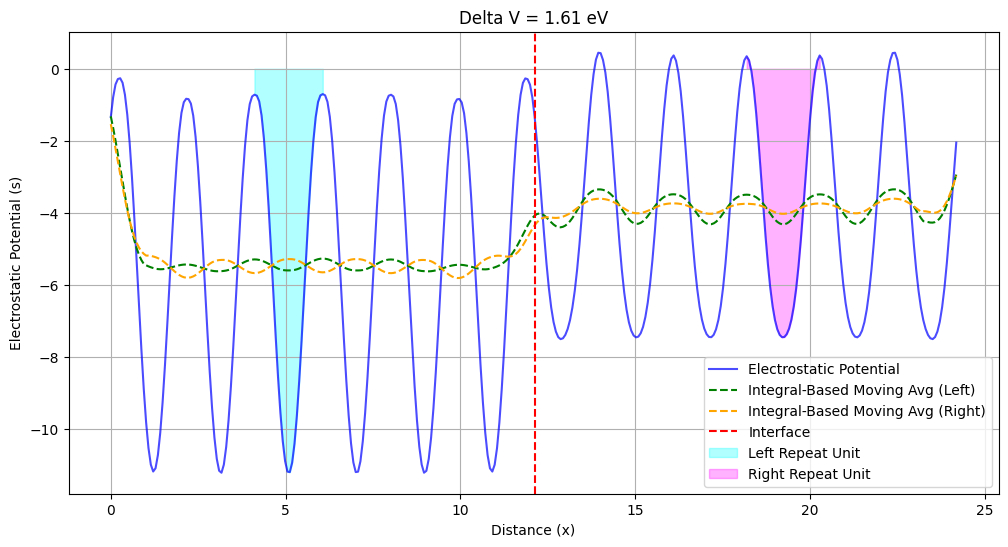

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from intermat.analyze import locpot_mean
%matplotlib inline
import matplotlib.pyplot as plt
# Load data from LOCPOT
x, s, _ = locpot_mean('LOCPOT')

# Step 1: Assume the middle is the interface
interface_index = len(x) // 2
interface_x = x[interface_index]

# Step 2: Identify peaks in the potential data to find repeat units
peaks, _ = find_peaks(s, width=5, prominence=1)
peak_positions = x[peaks]

# Step 3: Find the closest repeat unit lengths for left and right sides
left_side = peak_positions[peak_positions < interface_x]
left_index = int(np.ceil(len(left_side) / 2)) - 1
left_repeat_end = left_side[left_index]
left_repeat_start = peak_positions[peak_positions < left_repeat_end][-1]
left_repeat_length = left_repeat_end - left_repeat_start

right_side = peak_positions[peak_positions > interface_x]
right_index = int(np.ceil(len(right_side) / 2)) - 1
right_repeat_start = right_side[right_index]
right_repeat_end = peak_positions[peak_positions > right_repeat_start][0]
right_repeat_length = right_repeat_end - right_repeat_start

# Step 4: Calculate integral-based moving averages for left and right sides
def moving_average_integral(x, s, repeat_length):
    """
    Calculate integral-based moving average over a sliding window of size `repeat_length`.
    """
    moving_avg = []
    half_window = repeat_length / 2
    for center in x:
        start = center - half_window
        end = center + half_window
        mask = (x >= start) & (x <= end)
        if np.any(mask):
            integral = np.trapz(s[mask], x[mask]) / repeat_length
            moving_avg.append(integral)
        else:
            moving_avg.append(np.nan)  # Outside valid range
    return np.array(moving_avg)

# Calculate moving averages
moving_avg_left = moving_average_integral(x, s, left_repeat_length)
moving_avg_right = moving_average_integral(x, s, right_repeat_length)

# Step 5: Calculate the difference between the two integrals
mask_left = (x >= left_repeat_start) & (x <= left_repeat_end)
integral_left = np.trapz(s[mask_left], x[mask_left]) / left_repeat_length

mask_right = (x >= right_repeat_start) & (x <= right_repeat_end)
integral_right = np.trapz(s[mask_right], x[mask_right]) / right_repeat_length

integral_difference = integral_right - integral_left

# Print results
print(f"Left Repeat Unit: [{left_repeat_start}, {left_repeat_end}]")
print(f"Right Repeat Unit: [{right_repeat_start}, {right_repeat_end}]")
print(f"Left Repeat Length: {left_repeat_length}")
print(f"Right Repeat Length: {right_repeat_length}")
print(f"Integral over Left-Hand Side Repeat Unit: {integral_left}")
print(f"Integral over Right-Hand Side Repeat Unit: {integral_right}")
print(f"Difference Between Integrals: {integral_difference}")

# Visualize
plt.figure(figsize=(12, 6))
plt.plot(x, s, label="Electrostatic Potential", color="blue", alpha=0.7)
plt.plot(x, moving_avg_left, label="Integral-Based Moving Avg (Left)", color="green", linestyle="--")
plt.plot(x, moving_avg_right, label="Integral-Based Moving Avg (Right)", color="orange", linestyle="--")
plt.axvline(x=interface_x, color="red", linestyle="--", label="Interface")
plt.fill_between(x[mask_left], s[mask_left], color="cyan", alpha=0.3, label="Left Repeat Unit")
plt.fill_between(x[mask_right], s[mask_right], color="magenta", alpha=0.3, label="Right Repeat Unit")
plt.xlabel("Distance (x)")
plt.ylabel("Electrostatic Potential (s)")
plt.title(f"Delta V = {round(integral_difference, 2)} eV")
plt.legend()
plt.grid()
plt.show()


Extra stuff

Atoms(symbols='As12Ga12Si24', pbc=True, cell=[[0.002228, 5.5913, -0.003881], [7.884492, -0.002696, 0.625022], [-2.057968, -0.01637, -24.091262]])
gap OUTCAR (0.6234999999999999, 5.2089, 4.5854) 4.7982
avg_mx 0.4470960134154023
left_side [ 0.26940398  2.15523187  4.10841075  6.06158963  8.01476851  9.96794739
 11.85377528] 7 3
right_side [13.94165615 16.09688802 18.18476889 20.27264977 22.42788163] 5 2
Left Repeat Unit: [4.108410749810933, 6.061589630868589]
Right Repeat Unit: [18.184768892605767, 20.272649765460503]
Integral over Left-Hand Side Repeat Unit: -10.993212027567518
Integral over Right-Hand Side Repeat Unit: -8.392714196392216
Difference Between Integrals: 2.6004978311753018


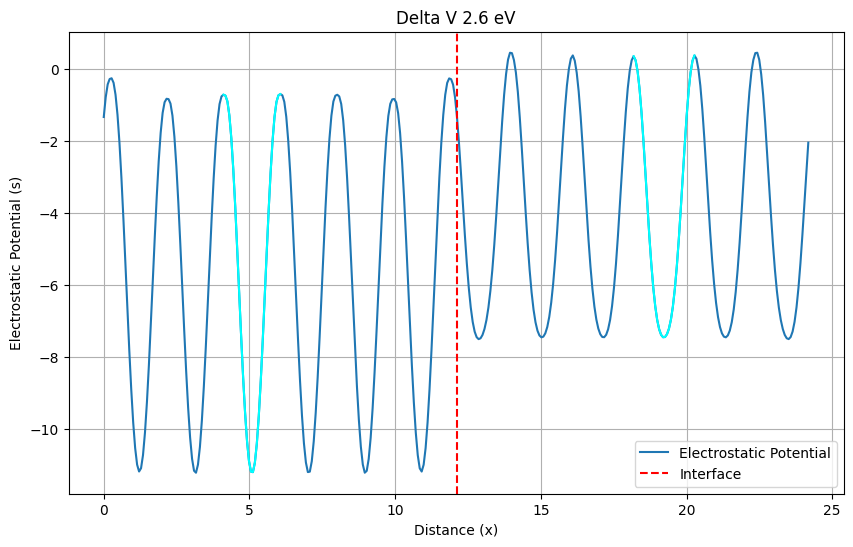

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from intermat.analyze import locpot_mean
%matplotlib inline
import matplotlib.pyplot as plt


x, s, _ = locpot_mean('LOCPOT')


# Step 1: Assume the middle is the interface
interface_index = len(x) // 2
interface_x = x[interface_index]

# Step 2: Identify peaks in the potential data to find repeat units
peaks, _ = find_peaks(s, width=5,prominence=1)
peak_positions = x[peaks]

# Step 3: Find the closest repeat unit to the left and right of the interface
left_side=peak_positions[peak_positions < interface_x]
left_index=int(np.ceil(len(left_side)/2))-1
print('left_side',left_side,len(left_side),left_index)
left_repeat_end = left_side[left_index]
left_repeat_start = peak_positions[peak_positions < left_repeat_end][-1]

right_side=peak_positions[peak_positions > interface_x]
right_index=int(np.ceil(len(right_side)/2))-1

print('right_side',right_side,len(right_side),right_index)

right_repeat_start = right_side[right_index]
right_repeat_end = peak_positions[peak_positions > right_repeat_start][0]

# Step 4: Calculate integrals over the left and right repeat units
# Left-hand side repeat unit
mask_left = (x >= left_repeat_start) & (x <= left_repeat_end)
integral_left = np.trapz(s[mask_left], x[mask_left])

# Right-hand side repeat unit
mask_right = (x >= right_repeat_start) & (x <= right_repeat_end)
integral_right = np.trapz(s[mask_right], x[mask_right])

# Step 5: Calculate the difference between the two integrals
integral_difference = integral_right - integral_left

# Print results
print(f"Left Repeat Unit: [{left_repeat_start}, {left_repeat_end}]")
print(f"Right Repeat Unit: [{right_repeat_start}, {right_repeat_end}]")
print(f"Integral over Left-Hand Side Repeat Unit: {integral_left}")
print(f"Integral over Right-Hand Side Repeat Unit: {integral_right}")
print(f"Difference Between Integrals: {integral_difference}")

# Visualize
plt.figure(figsize=(10, 6))
plt.plot(x, s, label="Electrostatic Potential")
plt.axvline(x=interface_x, color="red", linestyle="--", label="Interface")
plt.plot(x[mask_left], s[mask_left],  color="cyan")
plt.plot(x[mask_right], s[mask_right],color="cyan" )
plt.xlabel("Distance (x)")
plt.ylabel("Electrostatic Potential (s)")
plt.title("Delta V "+str(round(integral_difference,2))+" eV")
plt.legend()
plt.grid()
plt.show()


Left Repeat Unit: [4.108410749810933, 6.061589630868589]
Right Repeat Unit: [18.184768892605767, 20.272649765460503]
Integral over Left-Hand Side Repeat Unit: -10.993212027567518
Integral over Right-Hand Side Repeat Unit: -8.392714196392216
Difference Between Integrals: 2.6004978311753018
Average Potential (Left): -5.464462918301655
Average Potential (Right): -3.882876933576317
Left Line: y1 = -0.05x + -5.23
Right Line: y2 = -0.04x + -3.06
y2 - y1 at interface_x (12.12): 2.21


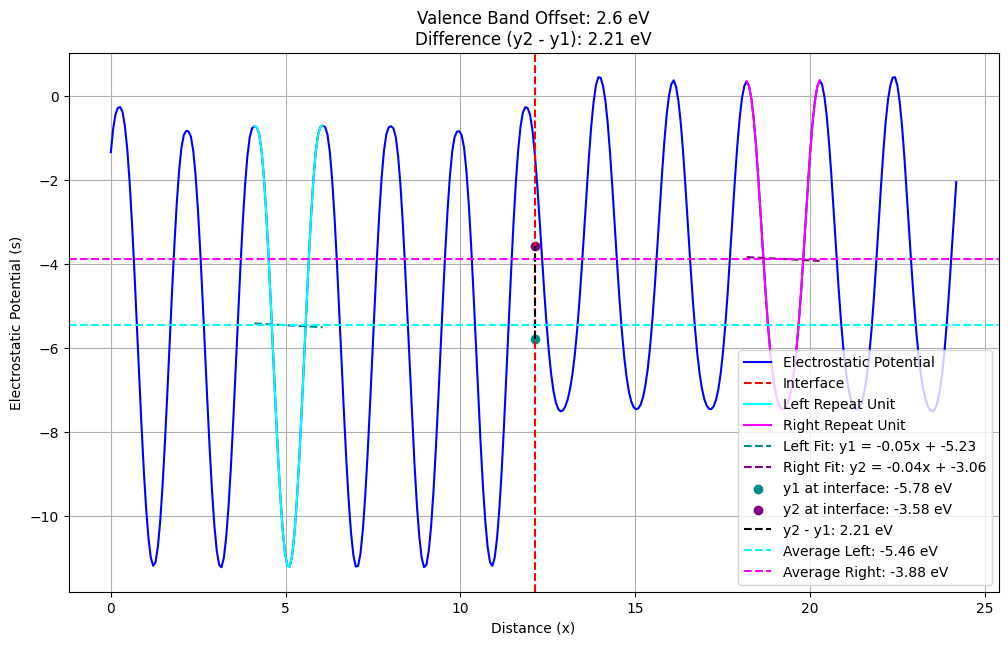

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.stats import linregress
from intermat.analyze import locpot_mean

%matplotlib inline

# Load the potential data
# x, s, _ = locpot_mean('LOCPOT')


# Step 1: Assume the middle is the interface
interface_index = len(x) // 2
interface_x = x[interface_index]

# Step 2: Identify peaks in the potential data to find repeat units
peaks, _ = find_peaks(s, width=5, prominence=1)
peak_positions = x[peaks]

# Step 3: Find the closest repeat unit to the left and right of the interface
left_side = peak_positions[peak_positions < interface_x]
left_index = int(np.ceil(len(left_side) / 2)) - 1
left_repeat_end = left_side[left_index]
left_repeat_start = peak_positions[peak_positions < left_repeat_end][-1]

right_side = peak_positions[peak_positions > interface_x]
right_index = int(np.ceil(len(right_side) / 2)) - 1
right_repeat_start = right_side[right_index]
right_repeat_end = peak_positions[peak_positions > right_repeat_start][0]

# Step 4: Calculate integrals and averages over the left and right repeat units
# Left-hand side repeat unit
mask_left = (x >= left_repeat_start) & (x <= left_repeat_end)
integral_left = np.trapz(s[mask_left], x[mask_left])
average_left = np.mean(s[mask_left])

# Right-hand side repeat unit
mask_right = (x >= right_repeat_start) & (x <= right_repeat_end)
integral_right = np.trapz(s[mask_right], x[mask_right])
average_right = np.mean(s[mask_right])

# Step 5: Fit straight lines to the left and right regions
# Linear fit for the left region
slope_left, intercept_left, _, _, _ = linregress(x[mask_left], s[mask_left])
line_left = slope_left * x[mask_left] + intercept_left

# Linear fit for the right region
slope_right, intercept_right, _, _, _ = linregress(x[mask_right], s[mask_right])
line_right = slope_right * x[mask_right] + intercept_right

# Calculate y1 and y2 at the interface point
y1 = slope_left * interface_x + intercept_left
y2 = slope_right * interface_x + intercept_right
y_diff = y2 - y1

# Step 6: Calculate the difference between the two integrals
integral_difference = integral_right - integral_left

# Print results
print(f"Left Repeat Unit: [{left_repeat_start}, {left_repeat_end}]")
print(f"Right Repeat Unit: [{right_repeat_start}, {right_repeat_end}]")
print(f"Integral over Left-Hand Side Repeat Unit: {integral_left}")
print(f"Integral over Right-Hand Side Repeat Unit: {integral_right}")
print(f"Difference Between Integrals: {integral_difference}")
print(f"Average Potential (Left): {average_left}")
print(f"Average Potential (Right): {average_right}")
print(f"Left Line: y1 = {slope_left:.2f}x + {intercept_left:.2f}")
print(f"Right Line: y2 = {slope_right:.2f}x + {intercept_right:.2f}")
print(f"y2 - y1 at interface_x ({interface_x:.2f}): {y_diff:.2f}")

# Visualize
plt.figure(figsize=(12, 7))
plt.plot(x, s, label="Electrostatic Potential", color="blue")
plt.axvline(x=interface_x, color="red", linestyle="--", label="Interface")
plt.plot(x[mask_left], s[mask_left], color="cyan", label="Left Repeat Unit")
plt.plot(x[mask_right], s[mask_right], color="magenta", label="Right Repeat Unit")

# Plot fitted lines
plt.plot(x[mask_left], line_left, color="darkcyan", linestyle="--", label=f"Left Fit: y1 = {slope_left:.2f}x + {intercept_left:.2f}")
plt.plot(x[mask_right], line_right, color="purple", linestyle="--", label=f"Right Fit: y2 = {slope_right:.2f}x + {intercept_right:.2f}")

# Mark y1 and y2 at the interface point
plt.scatter(interface_x, y1, color="darkcyan", label=f"y1 at interface: {y1:.2f} eV")
plt.scatter(interface_x, y2, color="purple", label=f"y2 at interface: {y2:.2f} eV")
plt.plot([interface_x, interface_x], [y1, y2], color="black", linestyle="--", label=f"y2 - y1: {y_diff:.2f} eV")

# Plot averages
plt.axhline(y=average_left, color="cyan", linestyle="--", label=f"Average Left: {average_left:.2f} eV")
plt.axhline(y=average_right, color="magenta", linestyle="--", label=f"Average Right: {average_right:.2f} eV")

plt.xlabel("Distance (x)")
plt.ylabel("Electrostatic Potential (s)")
plt.title(f"Valence Band Offset: {round(integral_difference, 2)} eV\nDifference (y2 - y1): {y_diff:.2f} eV")
plt.legend()
plt.grid()
plt.show()


Obtaining 3D dataset 76k ...
Reference:https://www.nature.com/articles/s41524-020-00440-1
Other versions:https://doi.org/10.6084/m9.figshare.6815699


100%|██████████| 40.8M/40.8M [00:02<00:00, 17.8MiB/s]


Loading the zipfile...
Loading completed.
Atoms(symbols='As12Ga12Si24', pbc=True, cell=[[0.002228, 5.5913, -0.003881], [7.884492, -0.002696, 0.625022], [-2.057968, -0.01637, -24.091262]])
gap OUTCAR (0.6234999999999999, 5.2089, 4.5854) 4.7982
avg_mx 0.4470960134154023
left_side [ 0.26940398  2.15523187  4.10841075  6.06158963  8.01476851  9.96794739
 11.85377528] 7 3
right_side [13.94165615 16.09688802 18.18476889 20.27264977 22.42788163] 5 2
Left Repeat Unit: [4.108410749810933, 6.061589630868589]
Right Repeat Unit: [18.184768892605767, 20.272649765460503]
Integral over Left-Hand Side Repeat Unit: -10.993212027567518
Integral over Right-Hand Side Repeat Unit: -8.392714196392216
Difference Between Integrals: 2.6004978311753018


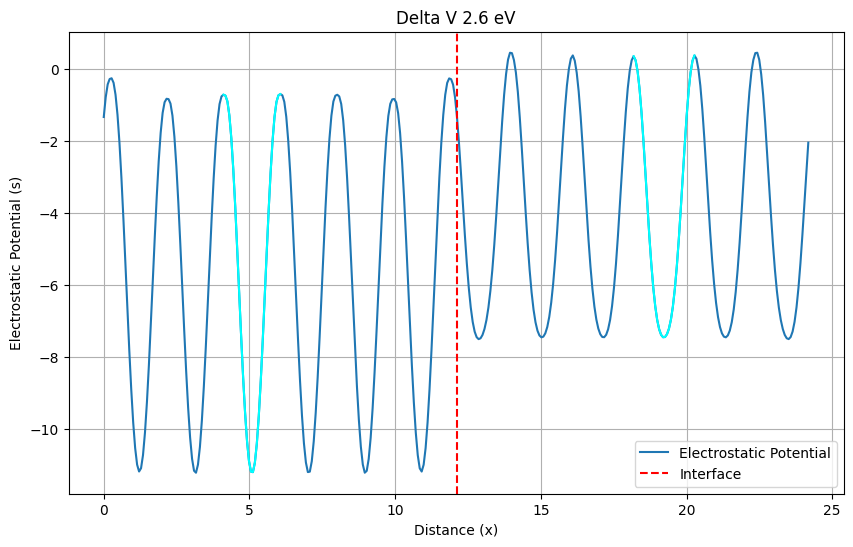

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from intermat.analyze import locpot_mean
%matplotlib inline
import matplotlib.pyplot as plt


x, s, _ = locpot_mean('LOCPOT')


# Step 1: Assume the middle is the interface
interface_index = len(x) // 2
interface_x = x[interface_index]

# Step 2: Identify peaks in the potential data to find repeat units
peaks, _ = find_peaks(s, width=5,prominence=1)
peak_positions = x[peaks]

# Step 3: Find the closest repeat unit to the left and right of the interface
left_side=peak_positions[peak_positions < interface_x]
left_index=int(np.ceil(len(left_side)/2))-1
print('left_side',left_side,len(left_side),left_index)
left_repeat_end = left_side[left_index]
left_repeat_start = peak_positions[peak_positions < left_repeat_end][-1]

right_side=peak_positions[peak_positions > interface_x]
right_index=int(np.ceil(len(right_side)/2))-1

print('right_side',right_side,len(right_side),right_index)

right_repeat_start = right_side[right_index]
right_repeat_end = peak_positions[peak_positions > right_repeat_start][0]

# Step 4: Calculate integrals over the left and right repeat units
# Left-hand side repeat unit
mask_left = (x >= left_repeat_start) & (x <= left_repeat_end)
integral_left = np.trapz(s[mask_left], x[mask_left])

# Right-hand side repeat unit
mask_right = (x >= right_repeat_start) & (x <= right_repeat_end)
integral_right = np.trapz(s[mask_right], x[mask_right])

# Step 5: Calculate the difference between the two integrals
integral_difference = integral_right - integral_left

# Print results
print(f"Left Repeat Unit: [{left_repeat_start}, {left_repeat_end}]")
print(f"Right Repeat Unit: [{right_repeat_start}, {right_repeat_end}]")
print(f"Integral over Left-Hand Side Repeat Unit: {integral_left}")
print(f"Integral over Right-Hand Side Repeat Unit: {integral_right}")
print(f"Difference Between Integrals: {integral_difference}")

# Visualize
plt.figure(figsize=(10, 6))
plt.plot(x, s, label="Electrostatic Potential")
plt.axvline(x=interface_x, color="red", linestyle="--", label="Interface")
plt.plot(x[mask_left], s[mask_left],  color="cyan")
plt.plot(x[mask_right], s[mask_right],color="cyan" )
plt.xlabel("Distance (x)")
plt.ylabel("Electrostatic Potential (s)")
plt.title("Delta V "+str(round(integral_difference,2))+" eV")
plt.legend()
plt.grid()
plt.show()


Left Repeat Unit: [4.108410749810933, 6.061589630868589]
Right Repeat Unit: [18.184768892605767, 20.272649765460503]
Integral over Left-Hand Side Repeat Unit: -10.993212027567518
Integral over Right-Hand Side Repeat Unit: -8.392714196392216
Difference Between Integrals: 2.6004978311753018
Average Potential (Left): -5.464462918301655
Average Potential (Right): -3.882876933576317


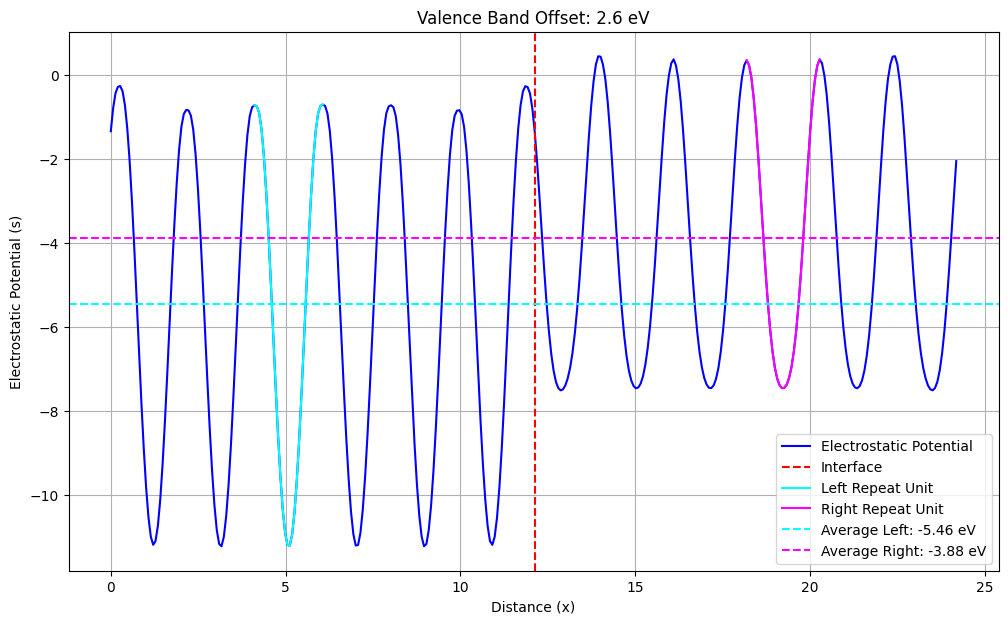

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from intermat.analyze import locpot_mean

%matplotlib inline

# Load the potential data
#x, s, _ = locpot_mean('LOCPOT')

# Step 1: Assume the middle is the interface
interface_index = len(x) // 2
interface_x = x[interface_index]

# Step 2: Identify peaks in the potential data to find repeat units
peaks, _ = find_peaks(s, width=5, prominence=1)
peak_positions = x[peaks]

# Step 3: Find the closest repeat unit to the left and right of the interface
left_side = peak_positions[peak_positions < interface_x]
left_index = int(np.ceil(len(left_side) / 2)) - 1
left_repeat_end = left_side[left_index]
left_repeat_start = peak_positions[peak_positions < left_repeat_end][-1]

right_side = peak_positions[peak_positions > interface_x]
right_index = int(np.ceil(len(right_side) / 2)) - 1
right_repeat_start = right_side[right_index]
right_repeat_end = peak_positions[peak_positions > right_repeat_start][0]

# Step 4: Calculate integrals and averages over the left and right repeat units
# Left-hand side repeat unit
mask_left = (x >= left_repeat_start) & (x <= left_repeat_end)
integral_left = np.trapz(s[mask_left], x[mask_left])
average_left = np.mean(s[mask_left])

# Right-hand side repeat unit
mask_right = (x >= right_repeat_start) & (x <= right_repeat_end)
integral_right = np.trapz(s[mask_right], x[mask_right])
average_right = np.mean(s[mask_right])

# Step 5: Calculate the difference between the two integrals
integral_difference = integral_right - integral_left

# Print results
print(f"Left Repeat Unit: [{left_repeat_start}, {left_repeat_end}]")
print(f"Right Repeat Unit: [{right_repeat_start}, {right_repeat_end}]")
print(f"Integral over Left-Hand Side Repeat Unit: {integral_left}")
print(f"Integral over Right-Hand Side Repeat Unit: {integral_right}")
print(f"Difference Between Integrals: {integral_difference}")
print(f"Average Potential (Left): {average_left}")
print(f"Average Potential (Right): {average_right}")

# Visualize
plt.figure(figsize=(12, 7))
plt.plot(x, s, label="Electrostatic Potential", color="blue")
plt.axvline(x=interface_x, color="red", linestyle="--", label="Interface")
plt.plot(x[mask_left], s[mask_left], color="cyan", label="Left Repeat Unit")
plt.plot(x[mask_right], s[mask_right], color="magenta", label="Right Repeat Unit")

# Plot averages
plt.axhline(y=average_left, color="cyan", linestyle="--", label=f"Average Left: {average_left:.2f} eV")
plt.axhline(y=average_right, color="magenta", linestyle="--", label=f"Average Right: {average_right:.2f} eV")

plt.xlabel("Distance (x)")
plt.ylabel("Electrostatic Potential (s)")
plt.title(f"Valence Band Offset: {round(integral_difference, 2)} eV")
plt.legend()
plt.grid()
plt.show()


Atoms(symbols='As12Ga12Si24', pbc=True, cell=[[0.002228, 5.5913, -0.003881], [7.884492, -0.002696, 0.625022], [-2.057968, -0.01637, -24.091262]])
gap OUTCAR (0.6234999999999999, 5.2089, 4.5854) 4.7982
avg_mx 0.4470960134154023
Left Repeat Unit: [4.108410749810933, 6.061589630868589]
Right Repeat Unit: [18.184768892605767, 20.272649765460503]
Integral over Left-Hand Side Repeat Unit: -10.993212027567518
Integral over Right-Hand Side Repeat Unit: -8.392714196392216
Difference Between Integrals: 2.6004978311753018
Average Potential (Left): -5.464462918301655
Average Potential (Right): -3.882876933576317
Left Line: y = -0.05x + -5.23
Right Line: y = -0.04x + -3.06


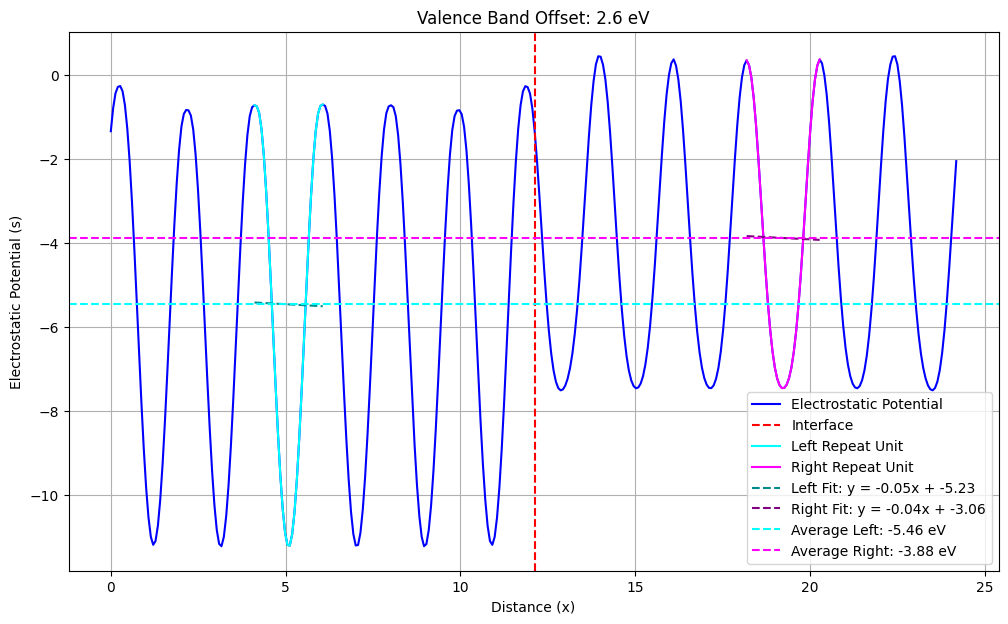

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.stats import linregress
from intermat.analyze import locpot_mean

%matplotlib inline

# Load the potential data
x, s, _ = locpot_mean('LOCPOT')



# Step 1: Assume the middle is the interface
interface_index = len(x) // 2
interface_x = x[interface_index]

# Step 2: Identify peaks in the potential data to find repeat units
peaks, _ = find_peaks(s, width=5, prominence=1)
peak_positions = x[peaks]

# Step 3: Find the closest repeat unit to the left and right of the interface
left_side = peak_positions[peak_positions < interface_x]
left_index = int(np.ceil(len(left_side) / 2)) - 1
left_repeat_end = left_side[left_index]
left_repeat_start = peak_positions[peak_positions < left_repeat_end][-1]

right_side = peak_positions[peak_positions > interface_x]
right_index = int(np.ceil(len(right_side) / 2)) - 1
right_repeat_start = right_side[right_index]
right_repeat_end = peak_positions[peak_positions > right_repeat_start][0]

# Step 4: Calculate integrals and averages over the left and right repeat units
# Left-hand side repeat unit
mask_left = (x >= left_repeat_start) & (x <= left_repeat_end)
integral_left = np.trapz(s[mask_left], x[mask_left])
average_left = np.mean(s[mask_left])

# Right-hand side repeat unit
mask_right = (x >= right_repeat_start) & (x <= right_repeat_end)
integral_right = np.trapz(s[mask_right], x[mask_right])
average_right = np.mean(s[mask_right])

# Step 5: Fit straight lines to the left and right regions
# Linear fit for the left region
slope_left, intercept_left, _, _, _ = linregress(x[mask_left], s[mask_left])
line_left = slope_left * x[mask_left] + intercept_left

# Linear fit for the right region
slope_right, intercept_right, _, _, _ = linregress(x[mask_right], s[mask_right])
line_right = slope_right * x[mask_right] + intercept_right

# Step 6: Calculate the difference between the two integrals
integral_difference = integral_right - integral_left

# Print results
print(f"Left Repeat Unit: [{left_repeat_start}, {left_repeat_end}]")
print(f"Right Repeat Unit: [{right_repeat_start}, {right_repeat_end}]")
print(f"Integral over Left-Hand Side Repeat Unit: {integral_left}")
print(f"Integral over Right-Hand Side Repeat Unit: {integral_right}")
print(f"Difference Between Integrals: {integral_difference}")
print(f"Average Potential (Left): {average_left}")
print(f"Average Potential (Right): {average_right}")
print(f"Left Line: y = {slope_left:.2f}x + {intercept_left:.2f}")
print(f"Right Line: y = {slope_right:.2f}x + {intercept_right:.2f}")

# Visualize
plt.figure(figsize=(12, 7))
plt.plot(x, s, label="Electrostatic Potential", color="blue")
plt.axvline(x=interface_x, color="red", linestyle="--", label="Interface")
plt.plot(x[mask_left], s[mask_left], color="cyan", label="Left Repeat Unit")
plt.plot(x[mask_right], s[mask_right], color="magenta", label="Right Repeat Unit")

# Plot fitted lines
plt.plot(x[mask_left], line_left, color="darkcyan", linestyle="--", label=f"Left Fit: y = {slope_left:.2f}x + {intercept_left:.2f}")
plt.plot(x[mask_right], line_right, color="purple", linestyle="--", label=f"Right Fit: y = {slope_right:.2f}x + {intercept_right:.2f}")

# Plot averages
plt.axhline(y=average_left, color="cyan", linestyle="--", label=f"Average Left: {average_left:.2f} eV")
plt.axhline(y=average_right, color="magenta", linestyle="--", label=f"Average Right: {average_right:.2f} eV")

plt.xlabel("Distance (x)")
plt.ylabel("Electrostatic Potential (s)")
plt.title(f"Valence Band Offset: {round(integral_difference, 2)} eV")
plt.legend()
plt.grid()
plt.show()


Left Repeat Unit: [4.108410749810933, 6.061589630868589]
Right Repeat Unit: [18.184768892605767, 20.272649765460503]
Integral over Left-Hand Side Repeat Unit: -10.993212027567518
Integral over Right-Hand Side Repeat Unit: -8.392714196392216
Difference Between Integrals: 2.6004978311753018
Average Potential (Left): -5.464462918301655
Average Potential (Right): -3.882876933576317
Left Line: y1 = -0.05x + -5.23
Right Line: y2 = -0.04x + -3.06
y2 - y1 at interface_x (12.12): 2.21


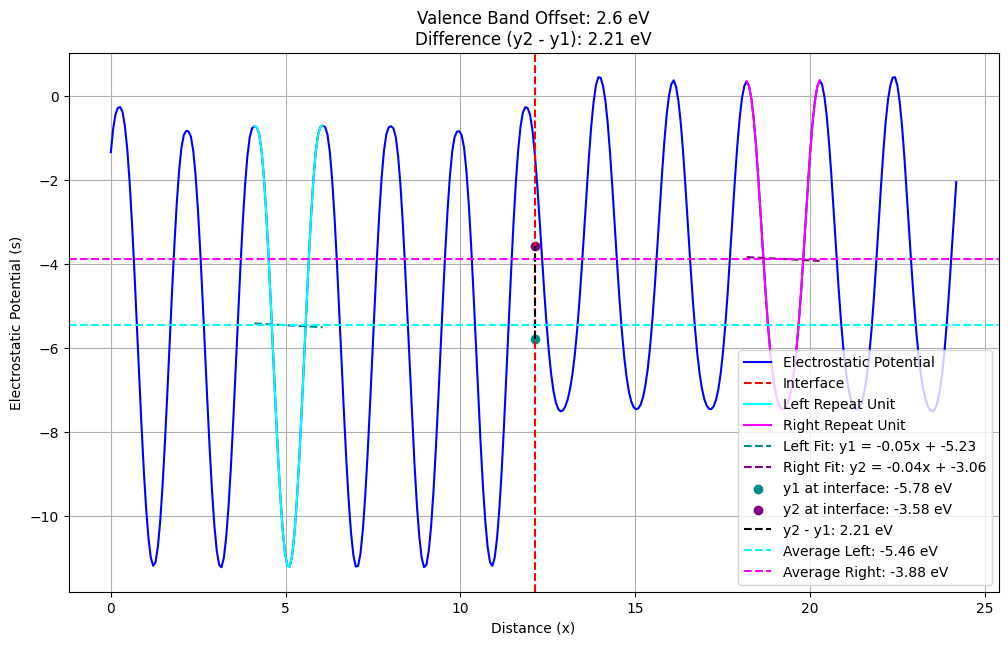

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.stats import linregress
from intermat.analyze import locpot_mean

%matplotlib inline

# Load the potential data
# x, s, _ = locpot_mean('LOCPOT')


# Step 1: Assume the middle is the interface
interface_index = len(x) // 2
interface_x = x[interface_index]

# Step 2: Identify peaks in the potential data to find repeat units
peaks, _ = find_peaks(s, width=5, prominence=1)
peak_positions = x[peaks]

# Step 3: Find the closest repeat unit to the left and right of the interface
left_side = peak_positions[peak_positions < interface_x]
left_index = int(np.ceil(len(left_side) / 2)) - 1
left_repeat_end = left_side[left_index]
left_repeat_start = peak_positions[peak_positions < left_repeat_end][-1]

right_side = peak_positions[peak_positions > interface_x]
right_index = int(np.ceil(len(right_side) / 2)) - 1
right_repeat_start = right_side[right_index]
right_repeat_end = peak_positions[peak_positions > right_repeat_start][0]

# Step 4: Calculate integrals and averages over the left and right repeat units
# Left-hand side repeat unit
mask_left = (x >= left_repeat_start) & (x <= left_repeat_end)
integral_left = np.trapz(s[mask_left], x[mask_left])
average_left = np.mean(s[mask_left])

# Right-hand side repeat unit
mask_right = (x >= right_repeat_start) & (x <= right_repeat_end)
integral_right = np.trapz(s[mask_right], x[mask_right])
average_right = np.mean(s[mask_right])

# Step 5: Fit straight lines to the left and right regions
# Linear fit for the left region
slope_left, intercept_left, _, _, _ = linregress(x[mask_left], s[mask_left])
line_left = slope_left * x[mask_left] + intercept_left

# Linear fit for the right region
slope_right, intercept_right, _, _, _ = linregress(x[mask_right], s[mask_right])
line_right = slope_right * x[mask_right] + intercept_right

# Calculate y1 and y2 at the interface point
y1 = slope_left * interface_x + intercept_left
y2 = slope_right * interface_x + intercept_right
y_diff = y2 - y1

# Step 6: Calculate the difference between the two integrals
integral_difference = integral_right - integral_left

# Print results
print(f"Left Repeat Unit: [{left_repeat_start}, {left_repeat_end}]")
print(f"Right Repeat Unit: [{right_repeat_start}, {right_repeat_end}]")
print(f"Integral over Left-Hand Side Repeat Unit: {integral_left}")
print(f"Integral over Right-Hand Side Repeat Unit: {integral_right}")
print(f"Difference Between Integrals: {integral_difference}")
print(f"Average Potential (Left): {average_left}")
print(f"Average Potential (Right): {average_right}")
print(f"Left Line: y1 = {slope_left:.2f}x + {intercept_left:.2f}")
print(f"Right Line: y2 = {slope_right:.2f}x + {intercept_right:.2f}")
print(f"y2 - y1 at interface_x ({interface_x:.2f}): {y_diff:.2f}")

# Visualize
plt.figure(figsize=(12, 7))
plt.plot(x, s, label="Electrostatic Potential", color="blue")
plt.axvline(x=interface_x, color="red", linestyle="--", label="Interface")
plt.plot(x[mask_left], s[mask_left], color="cyan", label="Left Repeat Unit")
plt.plot(x[mask_right], s[mask_right], color="magenta", label="Right Repeat Unit")

# Plot fitted lines
plt.plot(x[mask_left], line_left, color="darkcyan", linestyle="--", label=f"Left Fit: y1 = {slope_left:.2f}x + {intercept_left:.2f}")
plt.plot(x[mask_right], line_right, color="purple", linestyle="--", label=f"Right Fit: y2 = {slope_right:.2f}x + {intercept_right:.2f}")

# Mark y1 and y2 at the interface point
plt.scatter(interface_x, y1, color="darkcyan", label=f"y1 at interface: {y1:.2f} eV")
plt.scatter(interface_x, y2, color="purple", label=f"y2 at interface: {y2:.2f} eV")
plt.plot([interface_x, interface_x], [y1, y2], color="black", linestyle="--", label=f"y2 - y1: {y_diff:.2f} eV")

# Plot averages
plt.axhline(y=average_left, color="cyan", linestyle="--", label=f"Average Left: {average_left:.2f} eV")
plt.axhline(y=average_right, color="magenta", linestyle="--", label=f"Average Right: {average_right:.2f} eV")

plt.xlabel("Distance (x)")
plt.ylabel("Electrostatic Potential (s)")
plt.title(f"Valence Band Offset: {round(integral_difference, 2)} eV\nDifference (y2 - y1): {y_diff:.2f} eV")
plt.legend()
plt.grid()
plt.show()


Old approach

Check polar False
Number of peaks  11
use input left index
left index  -2
Initial guess left  2.0205298769561963
Lleft  2.0955117990772294


/usr/local/lib/python3.10/dist-packages/intermat/analyze.py:206: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  m, c = lstsq(A, y)[0]


Initial guess right  1.8858278851591166
Lright  1.9468003430130245
meanval  [-4.001625310860106, -5.649582614872947] -1.6479573040128406 -1.6479573040128406
deltaE 0


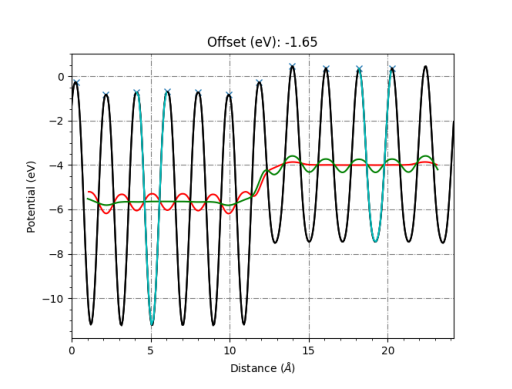

In [ ]:
from intermat.analyze import locpot_mean, offset
info=offset(x=x,s=s,polar=False,deltaE=0,left_index=-2)
plt.imshow(plt.imread('offset.png'))
plt.axis('off')
plt.show()

# Note Delta_V not offset, as deltaE manually set to zeo